In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# change to False, if you are not using dark mode
dark_mode = False

# adapts matplotlib color settings to work with dark mode

if dark_mode:
    text_color = "white"
    face_color = "black"
else:
    text_color = "black"
    face_color = "grey"
plt.rcParams['text.color'] = text_color
plt.rcParams['axes.labelcolor'] = text_color 
plt.rcParams['xtick.color'] = text_color
plt.rcParams['ytick.color'] = text_color
plt.rcParams['legend.facecolor'] = face_color

- equations of QIF neuron and QIF mean-field model with SFA
- parameter continuation for QIF mean-field model with low SFA
- Fold curve continuation in 2D parameter space
- parameter continuation for QIF mean-field model with high SFA
- Limit cycle continuation
- Hopf curve continuation in 2D parameter space
- example simulations

# Numerical Bifurcation Analysis

<br/>

In this notebook, you will apply methods such as numerical parameter continuation and automated bifurcation analysis via a high-level interface to Auto-07p.
We will continue to work with the Izhikevich neuron as an example model, but study bifurcations at the network level, rather than the single-neuron level.

<br/>

## Mean-field equations for Spiking Neural Networks

<br/>

In the previous notebook, we studied networks of coupled spiking neurons.
Due to the discontinuity around the spike (due to the resetting mechanism), we cannot study these networks via tools from bifurcation analysis.

This is why, in this part, we study mean-field equations of the network dynamics instead.
We have learned already that network-wide quantities such as the average membrane potential are the crucial information carrying variables when it comes to the dynamic state that the entire network is in.
Mean-field equations provide the means to study these network-wide quantities directly.
They are continous-valued models that have been derived from the spiking neural network equations.
This relationship is depicted below:

<img src="img/neco_micro_macro.png" width="800">

The particular set of mean-field equations for networks of coupled Izhikevich neurons that we will study is provided below:

$$ C \dot{r} = \frac{\Delta_v k^2 \sigma_v}{\pi C} (v-v_r) + r[k(2 v - v_r - \bar v_{\theta}) - g s],$$
$$ C \dot{v} = k v(v -v_r-\bar v_{\theta}) - \pi C r(\Delta_v \sigma_v + \frac{\pi C}{k} r) + k v_r \bar v_{\theta} - u + I  + g s (E-v), $$
$$ \tau_u \dot{u} = b(v-v_r) - u + \tau_u \kappa r, $$
$$ \tau_s \dot{s} = -s + \tau_s J r. $$

For more information on how these mean-field equations can be derived from the network equations of coupled Izhikevich neurons, see [this paper](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.107.024306).
Importantly, these four coupled differential equations approximatively capture the dynamics of the average firing rate $r$, the average membrane potential $v$, the average recovery variable $u$, and the global synaptic input $s$ of an Izhikevich neural network with distributed spike thresholds $v_t$.

It is this set of equations and its parameter dependencies that we will study via bifurcation analysis below.

## Parameter Continuations via PyCoBi

To study how the equilibrium structure of the mean-field equations changes as a function of one of its parameter, we can use [numerical continuation](https://en.wikipedia.org/wiki/Numerical_continuation).

<br/>

However, as a first step, we have to find a stable solution of the system dynamics.
Every numerical continuation algorithm requires a stable solution for a particular choice of the parameter.
Based on this initial solution, the algorithm can then detect how small changes in the parameter translate to changes in the stable solution.

<br/>

Let's find such a solution via a numerical simulation for a particular parameter set of our mean-field equations.
To this end, we use the pre-implemented mean-field equations in the dynamical systems modeling tool [PyRates](https://github.com/pyrates-neuroscience/PyRates).

<br/>

Let's run the cell below to perform the simulation and observe whether the model converged to a stable solution.

In [2]:
from pyrates import CircuitTemplate

# initialize mean-field model
ik_mf = CircuitTemplate.from_yaml("model_templates.neural_mass_models.ik.ik_theta")

# set the initial value of all model parameters
mf_params = {"C": 100.0, "k": 0.7, "v_r": -60.0, "v_t": -40.0, "b": -2.0, "g": 15.0,
             "a": 0.03, "d": 10.0, "tau_s": 6.0, "E_r": 0.0, "eta": 70.0, "Delta": 1.0}
ik_mf.update_var(node_vars={f"p/ik_theta_op/{key}": val for key, val in mf_params.items()})

# define simulation parameters (time unit: ms)
T = 1000.0
dt = 1e-2
sr = 100

# perform mean-field simulation
res = ik_mf.run(simulation_time=T, step_size=dt, sampling_step_size=int(dt*sr), 
                outputs={"v": "p/ik_theta_op/v", "r": "p/ik_theta_op/r"}, 
                in_place=False, solver="scipy", atol=1e-7, rtol=1e-7)

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 0.1146418589996756s.


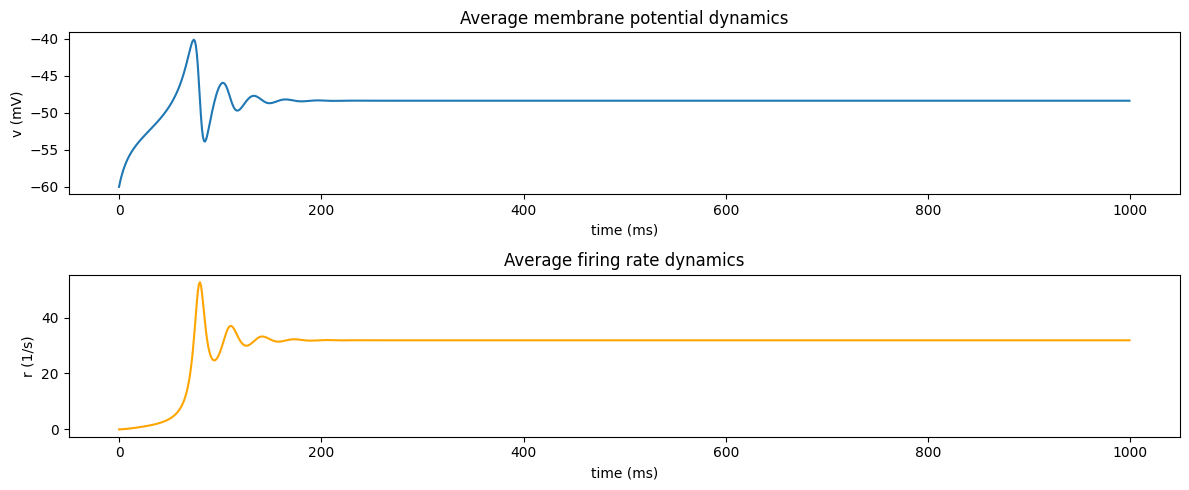

In [3]:
# plot results
_, axes = plt.subplots(nrows=2, figsize=(12, 5))
ax = axes[0]
ax.plot(res["v"])
ax.set_xlabel("time (ms)")
ax.set_ylabel("v (mV)")
ax.set_title("Average membrane potential dynamics")
ax = axes[1]
ax.plot(res["r"]*1e3, color="orange")
ax.set_xlabel("time (ms)")
ax.set_ylabel("r (1/s)")
ax.set_title("Average firing rate dynamics")
plt.tight_layout()

As we can see from the dynamics in the two state variables $v$ and $r$, the model seems to have converged to a stable state after initial fluctuations.
We can thus use the value of the state variables at the end of this simulation for parameter continuations.

<br/>

To run parameter continuations, PyCoBi will require user-supplied Fortran files that contain the model equations, parameters, and meta parameters for Auto-07p.
Don't worry, you wont have to write Fortran code yourself.

<br/>

PyRates provides a simple function call, which creates all necessary Fortran user files and writes them to a file in your working directory.
It will automatically use the lates values of all state variables and model parameters and thus make use of the stable state solution we just found. 

In [4]:
_, _, params, state_vars = ik_mf.get_run_func(
    func_name='ik_rhs', file_name='ik', step_size=dt, auto=True, backend='fortran', solver='scipy', 
    vectorize=False, float_precision='float64', in_place=False
)

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.


To perform parameter continuations as well as automated bifurcation analysis, we will use the software [PyCoBi](https://github.com/pyrates-neuroscience/PyCoBi), which is a Python wrapper to the Fortran software [Auto-07p](https://github.com/auto-07p/auto-07p). 
We can create a simple instance of the main PyCoBi class for parameter continuations and bifurcation analysis via the following line:

In [5]:
from pycobi import ODESystem

cont = ODESystem("ik", working_dir=None, auto_dir="~/PycharmProjects/auto-07p", init_cont=False, params=params[3:], state_vars=list(state_vars))

Let's have a look at the file that was created. This is what PyCoBi will use in the background to run fortran-based paramter continuations and bifurcation analysis:

In [6]:
f = open('ik.f90', 'r')
print('')
print(f.read())


module ik

double precision :: PI = 4.0*atan(1.0)

contains


subroutine ik_rhs(t,y,dy,v_t,v_r,k,g,Delta,C,E_r,I_ext,eta,b,a,d,tau_s)

implicit none

double precision, intent(in) :: t
double precision, intent(in) :: y(4)
double precision :: r
double precision :: v
double precision :: u
double precision :: s
double precision :: r_in
double precision, intent(inout) :: dy(4)
double precision, intent(in) :: v_t
double precision, intent(in) :: v_r
double precision, intent(in) :: k
double precision, intent(in) :: g
double precision, intent(in) :: Delta
double precision, intent(in) :: C
double precision, intent(in) :: E_r
double precision, intent(in) :: I_ext
double precision, intent(in) :: eta
double precision, intent(in) :: b
double precision, intent(in) :: a
double precision, intent(in) :: d
double precision, intent(in) :: tau_s


r = y(1)
v = y(2)
u = y(3)
s = y(4)
r_in = r

dy(1) = (r*(-g*s + k*(2.0*v - v_r - v_t)) + Delta*k**2*(v - v_r)&
     & /(pi*C))/C
dy(2) = (-pi*C*r*(pi*C*r/k &
 

You can either use the indiceNow we are ready to run parameter continuations via PyCoBi.

<br/>

### (I) Continuation of a known steady-state solution in one parameter

<br/>

As a first example, we will continue the solution that we obtained above in the parameter $\eta$, which can be viewed as a background input.
From reading in the Fortran file, we saw that $\eta$ is the $9$th parameter of the model. 
The cell below performs a continuation of the solution that we found previously in $\eta$:

In [7]:
algorithm_params = {"NTST": 400, "NCOL": 4, "IAD": 3, "IPLT": 0, "NBC": 0, "NINT": 0, "NMX": 4000, "NPR": 10,
                    "MXBF": 5, "IID": 2, "ITMX": 40, "ITNW": 40, "NWTN": 12, "JAC": 0, "EPSL": 1e-6, "EPSU": 1e-6,
                    "EPSS": 1e-4, "DS": 1e-4, "DSMIN": 1e-8, "DSMAX": 5e-2, "IADS": 1, "THL": {}, "THU": {}}

eta_solutions, eta_cont = cont.run(e="ik", c="ivp", name="eta", ICP=9, IPS=1, ILP=1, ISP=2, ISW=1, RL0=0.0, RL1=90, 
                                   UZR={}, STOP={}, bidirectional=True, **algorithm_params)

gfortran -g -fopenmp -O -c ik.f90 -o ik.o
gfortran -g -fopenmp -O ik.o -o ik.exe /home/rgf3807/PycharmProjects/auto-07p/lib/*.o
Starting ik ...

  BR    PT  TY  LAB    PAR(9)        L2-NORM         U(1)          U(2)          U(3)          U(4)     
   1     1  EP    1   7.00000E+01   4.99876E+01   3.18764E-02  -4.83577E+01  -1.26591E+01   1.91258E-01
   1    10        2   7.00512E+01   4.99864E+01   3.18863E-02  -4.83570E+01  -1.26573E+01   1.91318E-01
   1    20        3   7.05508E+01   4.99750E+01   3.19825E-02  -4.83498E+01  -1.26396E+01   1.91895E-01
   1    30        4   7.10504E+01   4.99637E+01   3.20782E-02  -4.83427E+01  -1.26219E+01   1.92469E-01
   1    40        5   7.15501E+01   4.99524E+01   3.21733E-02  -4.83356E+01  -1.26043E+01   1.93040E-01
   1    50        6   7.20497E+01   4.99412E+01   3.22680E-02  -4.83286E+01  -1.25868E+01   1.93608E-01
   1    60        7   7.25494E+01   4.99300E+01   3.23622E-02  -4.83216E+01  -1.25694E+01   1.94173E-01
   1    70        8   

   1   770       78   1.08030E+02   4.92603E+01   3.81317E-02  -4.79021E+01  -1.14852E+01   2.28790E-01
   1   780       79   1.08530E+02   4.92522E+01   3.82032E-02  -4.78970E+01  -1.14715E+01   2.29219E-01
   1   790       80   1.09030E+02   4.92441E+01   3.82745E-02  -4.78919E+01  -1.14580E+01   2.29647E-01
   1   800       81   1.09530E+02   4.92360E+01   3.83456E-02  -4.78869E+01  -1.14444E+01   2.30073E-01
   1   810       82   1.10029E+02   4.92279E+01   3.84164E-02  -4.78818E+01  -1.14309E+01   2.30498E-01
   1   820       83   1.10529E+02   4.92199E+01   3.84871E-02  -4.78768E+01  -1.14175E+01   2.30922E-01
   1   830       84   1.11029E+02   4.92119E+01   3.85575E-02  -4.78717E+01  -1.14040E+01   2.31345E-01
   1   840       85   1.11529E+02   4.92039E+01   3.86278E-02  -4.78667E+01  -1.13906E+01   2.31767E-01
   1   850       86   1.12029E+02   4.91960E+01   3.86978E-02  -4.78617E+01  -1.13773E+01   2.32187E-01
   1   860       87   1.12528E+02   4.91880E+01   3.87677E-02  -

   1  1560      157   1.47516E+02   4.86878E+01   4.32474E-02  -4.75408E+01  -1.05027E+01   2.59484E-01
   1  1570      158   1.48016E+02   4.86813E+01   4.33065E-02  -4.75366E+01  -1.04912E+01   2.59839E-01
   1  1580      159   1.48516E+02   4.86748E+01   4.33654E-02  -4.75325E+01  -1.04798E+01   2.60192E-01
   1  1590      160   1.49016E+02   4.86683E+01   4.34242E-02  -4.75284E+01  -1.04684E+01   2.60545E-01
   1  1600      161   1.49516E+02   4.86619E+01   4.34829E-02  -4.75243E+01  -1.04571E+01   2.60898E-01
   1  1610  EP  162   1.50016E+02   4.86555E+01   4.35415E-02  -4.75202E+01  -1.04457E+01   2.61249E-01

 Total Time    0.523E-01
ik ... done
Starting ik ...

  BR    PT  TY  LAB    PAR(9)        L2-NORM         U(1)          U(2)          U(3)          U(4)     
   1     1  EP    1   7.00000E+01   4.99876E+01   3.18764E-02  -4.83577E+01  -1.26591E+01   1.91258E-01
   1    10        2   6.99488E+01   4.99888E+01   3.18665E-02  -4.83584E+01  -1.26609E+01   1.91199E-01
   1    

   1   720       73   3.44952E+01   5.11198E+01   2.26409E-02  -4.90818E+01  -1.42895E+01   1.35845E-01
   1   730       74   3.39966E+01   5.11453E+01   2.24399E-02  -4.90987E+01  -1.43227E+01   1.34639E-01
   1   740       75   3.34981E+01   5.11714E+01   2.22340E-02  -4.91160E+01  -1.43566E+01   1.33404E-01
   1   750       76   3.29996E+01   5.11983E+01   2.20230E-02  -4.91339E+01  -1.43912E+01   1.32138E-01
   1   760       77   3.25012E+01   5.12259E+01   2.18062E-02  -4.91524E+01  -1.44265E+01   1.30837E-01
   1   770       78   3.20029E+01   5.12544E+01   2.15834E-02  -4.91714E+01  -1.44627E+01   1.29500E-01
   1   780       79   3.15046E+01   5.12838E+01   2.13539E-02  -4.91912E+01  -1.44997E+01   1.28123E-01
   1   790       80   3.10065E+01   5.13142E+01   2.11170E-02  -4.92116E+01  -1.45377E+01   1.26702E-01
   1   800       81   3.05085E+01   5.13457E+01   2.08721E-02  -4.92329E+01  -1.45768E+01   1.25233E-01
   1   810       82   3.00106E+01   5.13784E+01   2.06183E-02  -

   1  1490      152   3.40002E+01   5.64832E+01   7.58469E-04  -5.59298E+01  -7.88758E+00   4.55081E-03
   1  1500      153   3.35386E+01   5.65485E+01   7.31031E-04  -5.60194E+01  -7.71752E+00   4.38619E-03
   1  1510      154   3.30751E+01   5.66127E+01   7.05025E-04  -5.61068E+01  -7.55144E+00   4.23015E-03
   1  1520      155   3.26100E+01   5.66758E+01   6.80317E-04  -5.61921E+01  -7.38905E+00   4.08190E-03
   1  1530      156   3.21433E+01   5.67380E+01   6.56793E-04  -5.62755E+01  -7.23010E+00   3.94076E-03
   1  1540      157   3.16753E+01   5.67994E+01   6.34352E-04  -5.63571E+01  -7.07436E+00   3.80611E-03
   1  1550      158   3.12059E+01   5.68599E+01   6.12905E-04  -5.64370E+01  -6.92163E+00   3.67743E-03
   1  1560      159   3.07354E+01   5.69197E+01   5.92376E-04  -5.65154E+01  -6.77173E+00   3.55426E-03
   1  1570      160   3.02638E+01   5.69787E+01   5.72694E-04  -5.65923E+01  -6.62449E+00   3.43617E-03
   1  1580      161   2.97912E+01   5.70371E+01   5.53798E-04  -

Let's have a look at the resulting bifurcation diagram:

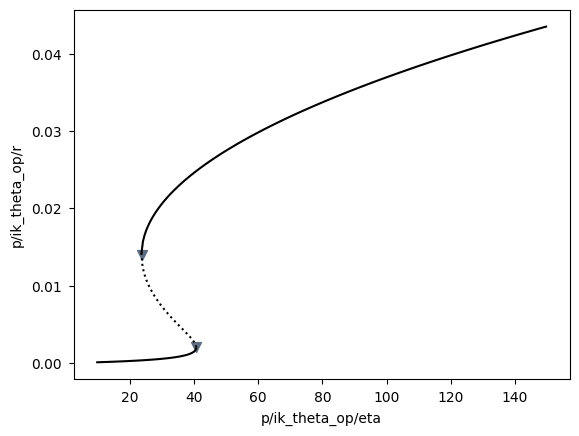

In [8]:
# plot the 1D bifurcation diagram
cont.plot_continuation("p/ik_theta_op/eta", "p/ik_theta_op/r", cont="eta")
plt.show()

This bifurcation diagram shows you the value of $r$ (y-axis) for a set of steady-state solutions with different values of $\eta$ (x-axis).
In addition, it shows you the stability of a solution at a given $\eta$ via the line type: Solid lines indicate stable solutions, whereas dotted lines indicate unstable solutions.
The steady-state solution curve changes stability twice in the investigated parameter regime. Both times, a stable solution branch looses stability via a fold bifurcation and gives rise to a branch of unstable solutions.
Within the parameter regime bounded by the two fold bifurcations, two stable solution branches exist.
Thus, for any value of $\eta$ within that parameter regime, the Izhikevich mean-field equations can converge to one of two stable states, depending on its initial conditions.
This explains the hysteresis behavior we observed earlier in the spiking neural network.

<br/>

Let's confirm the predictions of the bifurcation diagram again via a numerical simulation, where we initialize the system in the bi-stable regime at $\eta = 30$ pA and choose an initial condition such that the system converges to the low activity state. Then, we will apply a short extrinsic stimulation that effectively pushes the system over a fold bifurcation to $\eta = 50$ pA, thus inducing a transition to the high activity state.
We will then turn off the extrinsic stimulus and observe whether the system will linger around the high-activity state, thus prooving the existence of a second stable equilibrium, or whether it will transition back to its original state.

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 0.712316073000693s.


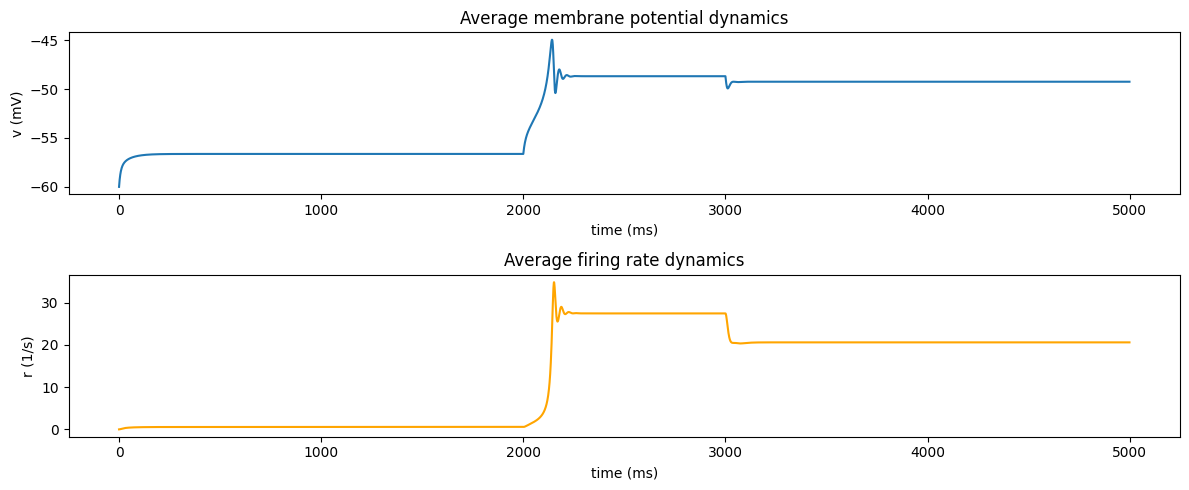

In [4]:
# define simulation parameters (time unit: ms)
T = 5000.0
dt = 1e-2
sr = 100

# define extrinsic input
start = int(2000.0/dt)
dur = int(1000.0/dt)
steps = int(T/dt)
inp = np.zeros((steps,))
inp[start:start+dur] = 20.0

# update model parameters and initial state
variables = {"eta": 30.0, "r": 0.0, "v": -60.0, "u": 0.0, "s": 0.0}
ik_mf.update_var(node_vars={f"p/ik_theta_op/{key}": val for key, val in variables.items()})

# perform mean-field simulation
res = ik_mf.run(simulation_time=T, step_size=dt, sampling_step_size=int(dt*sr), 
                outputs={"v": "p/ik_theta_op/v", "r": "p/ik_theta_op/r"}, 
                inputs={"p/ik_theta_op/I_ext": inp},
                in_place=False, solver="scipy", atol=1e-7, rtol=1e-7)

# plot results
_, axes = plt.subplots(nrows=2, figsize=(12, 5))
ax = axes[0]
ax.plot(res["v"])
ax.set_xlabel("time (ms)")
ax.set_ylabel("v (mV)")
ax.set_title("Average membrane potential dynamics")
ax = axes[1]
ax.plot(res["r"]*1e3, color="orange")
ax.set_xlabel("time (ms)")
ax.set_ylabel("r (1/s)")
ax.set_title("Average firing rate dynamics")
plt.tight_layout()

As we can see from the resulting dynamics, the system stays in a high activity state after we turn off the stimulation at $t = 3000$ ms.
Thus the system converged to a low activity state prior to the stimulus onset at $t = 2000$ ms, but converged to a high activity state after stimulation, despite the value of $\eta$ (and all other model parameters) being the same in both cases.
Thus, the system expresses two distinct stable equilibria for $\eta = 30$ pA.